# Đọc dữ liệu
Đọc ảnh images và labels (masks) được lấy từ cuộc thi phân loại ảnh vệ tinh của Kaggle(https://dida.do/downloads/dida-test-task)

Em có sử dụng các ứng dụng để vẽ được polygon mái nhà như labelme (file json) sau đó đọc ảnh bằng cv2 lưu lại các mái nhà dưới dạng ảnh nhị phân bitmask.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import imageio
%matplotlib inline



# reading the data
project_path = "D:\\TTNT_BTL\\Dectection-Roof\\"
images_path = os.path.join(project_path, "Data\\images\\")
labels_path = os.path.join(project_path, "Data\\labels\\")
images_list = os.listdir(images_path)
labels_list = os.listdir(labels_path)
images_dir_list = [images_path+i for i in images_list]
labels_dir_list = [labels_path+i for i in labels_list]


images = []
labels= []


for i in range(len(labels_dir_list)):
    img = imageio.imread(images_dir_list[i])
    bitMask = imageio.imread(labels_dir_list[i])
    bitMask = np.where(bitMask>0,1,0) # convert to binary mask
    images.append(img[:,:,:3]/255.) # remove the alpha channel
    labels.append(bitMask.reshape((256,256,1)))

    
    
images, labels = np.array(images), np.array(labels) 

print(images_dir_list)
print(labels_dir_list)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19768\1352332389.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(images_dir_list[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_19768\1352332389.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bitMask = imageio.imread(labels_dir_list[i])


['D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\121.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\241.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\270.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\272.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\274.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\278.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\284.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\287.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\300.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\301.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\303.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\308.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\314.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\315.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\317.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\320.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\324.png', 'D:\\TTNT_BTL\\Dectection-Roof\\Data\\images\\3

Vẽ biểu đồ dữ liệu bất kỳ.

In [2]:
i = np.random.randint(0, len(images_dir_list))
img, lbl = images[i], labels[i]
lbl = lbl.reshape((256,256,1))

print(images_dir_list[i], labels_dir_list[i])
print(i)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(lbl, cmap='gray')
arr[1].set_title('Segmentation')

D:\TTNT_BTL\Dectection-Roof\Data\images\301.png D:\TTNT_BTL\Dectection-Roof\Data\labels\301.png
9


Text(0.5, 1.0, 'Segmentation')

# Segmentation-models

Để thực hiện chuyển việc học cho mô hình phân đoạn, ở đây em sử dụng mô hình "segmentation_models" có sẵn trên https://segmentation-models.readthedocs.io/en/latest/tutorial.html. Tất cả các quá trình tiền xử lý và chuyển giao học tập đều được thực hiện tự động.

In [3]:
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
import keras

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input to be consistent with the trained network 
images_pro = preprocess_input1(images)


# test-train split
X_train, X_test, y_train, y_test = train_test_split(images_pro, labels, test_size = 0.2, random_state = 101)
print(X_train.shape)
print(X_test.shape)

Segmentation Models: using `keras` framework.
(20, 256, 256, 3)
(5, 256, 256, 3)


# Data Augmentation

Mục đích: 

- Tạo ra các phiên bản biến đổi của ảnh/mask gốc để:

- Tăng kích thước tập dữ liệu ảo

- Giúp mô hình học được tính bất biến (invariance) với các biến đổi hình học

- Chống overfitting

Ở đây chúng ta sử dụng 1 hàm để đảm bảo việc từng cặp ảnh sau khi augument được đồng bộ

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 101

image_generate = ImageDataGenerator(
    rotation_range = 90,          # Xoay ngẫu nhiên 0-90 độ
    width_shift_range = 0.3,      # Dịch ngang 30% chiều rộng
    height_shift_range = 0.3,     # Dịch dọc 30% chiều cao
    shear_range = 0.5,            # Biến dạng trượt (shear)
    zoom_range = 0.3,             # Phóng to/thu nhỏ 30%
    horizontal_flip = True,       # Lật ngang
    vertical_flip = True,         # Lật dọc
    fill_mode = 'reflect'         # Cách điền pixel khi biến đổi
)

image_generate.fit(X_train, augment=True, seed=seed)

image_generator = image_generate.flow(X_train, seed=seed) # Tạo batch dữ liệu từ X_train

validate_img_generator = image_generate.flow(X_test, seed=seed) # Tạo batch dữ liệu từ X_test

label_generate = ImageDataGenerator(
    rotation_range = 90, 
    width_shift_range = 0.3, 
    height_shift_range = 0.3,
    shear_range = 0.5, 
    zoom_range = 0.3, 
    horizontal_flip = True,
    vertical_flip = True, 
    fill_mode = 'reflect',
    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

label_generate.fit(y_train, augment=True, seed=seed)

label_generator = label_generate.flow(y_train, seed=seed) # Tạo batch dữ liệu từ y_train

validate_lbl_generator = label_generate.flow(y_test, seed=seed) # Tạo batch dữ liệu từ y_test

def image_mask_generator(image_generator, label_generator):
    train_generator = zip(image_generator, label_generator) # Kết hợp 2 generator
    for (img, mask) in train_generator:
        yield (img, mask) # Trả về 1 tuple (img, mask) từ 2 generator

my_generator = image_mask_generator(image_generator, label_generator)
validation_data = image_mask_generator(validate_img_generator, validate_lbl_generator)

## Huấn luyện mô hình Segmentation sử dụng kiến trúc UNet với BACKBONE Resnet34

Đoạn code dưới đây định nghĩa và huấn luyện mô hình segmentation sử dụng kiến trúc U-Net với backbone là ResNet34 (được xác định trước đó qua biến BACKBONE)

Em sử dụng UNet là kiến trúc phổ biến cho bài toán segmentation, Backbone (resnet34): Mạng CNN làm encoder để trích xuất đặc trưng.

Hàm mất mát bce_jaccard_loss là kết hợp giữa Binary Cross-Entropy (BCE) và Jaccard Loss (IoU Loss):
$$\text{Loss} = \text{BCE} + (1 - \text{IoU})$$
Cho từng pixel, công thức BCE như sau:
$$
BCE = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$

- \( y_i \): Giá trị thực của pixel (0 hoặc 1).  
- \( p_i \): Xác suất dự đoán pixel thuộc lớp 1 (trong khoảng \([0,1]\)).  
- \( N \): Tổng số pixel.  
Công thức tính chỉ số IoU đo độ chính xác vùng chồng lấn:
$$
IoU = \frac{\text{Predicted Mask} \cap \text{Ground Truth}}{\text{Predicted Mask} \cup \text{Ground Truth}}
$$

- **Giá trị IoU nằm trong khoảng [0, 1]:**
  - **0**: Dự đoán hoàn toàn sai (không có sự chồng lắp).
  - **1**: Dự đoán trùng khớp hoàn hảo với Ground Truth.


In [5]:
from tensorflow.keras.optimizers import Adam
sm.set_framework('tf.keras')

model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet'  # Sử dụng trọng số pretrained từ ImageNet
)
model.compile(
    optimizer='Adam',
    loss=sm.losses.bce_jaccard_loss,  # Kết hợp BCE và Jaccard Loss
    metrics=[sm.metrics.iou_score]    # Theo dõi IoU trong quá trình train
)

print(model.summary())

# Training the model
history = model.fit(            # Lưu giữ toàn bộ lịch sử huấn luyện
    my_generator,               # Generator cho tập train
    validation_data = validation_data,  # Generator cho tập validation
    steps_per_epoch = 50,        # Số batch mỗi epoch (tập train)
    validation_steps = 50,       # Số batch validation mỗi epoch
    epochs = 80                # Số epoch tối đa
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - iou_score: 0.3023 - loss: 1.1248 - val_iou_score: 0.2153 - val_loss: 9.5682
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - iou_score: 0.6502 - loss: 0.5230 - val_iou_score: 0.0985 - val_loss: 1.4553
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - iou_score: 0.7311 - loss: 0.3942 - val_iou_score: 0.0388 - val_loss: 2.9122
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - iou_score: 0.7149 - loss: 0.4380 - val_iou_score: 0.1670 - val_loss: 1.4557
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - iou_score: 0.7359 - loss: 0.3916 - val_iou_score: 0.0075 - val_loss: 2.1278
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - iou_score: 0.7562 - loss: 0.3545 - val_iou_score: 0.0024 - val_loss: 2.3406
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - iou_score: 0.7866 - loss: 0.3088 - val_iou_score: 0.1919 - val_loss: 2.0027
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - iou_score: 0.8032 - loss: 0.2870 - val_

Những vấn đề hiện tại
- Thời gian/epoch quá lâu (15p/epoch) -> Tăng batch_size hoặc đảm bảo GPU
- Validation loss tăng -> Thử giảm learning rate (đang mặc định là 1e-3)
- Overfitting (IoU train cao nhưng val thấp) -> Thêm Regularizationv, augmentation mạnh hơn, Early Stopping


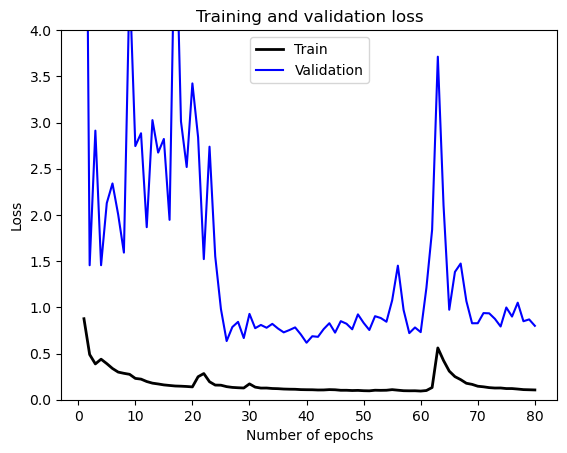

In [9]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
number_epochs = range(1, len(train_loss) + 1)

plt.plot(number_epochs, train_loss, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend()
plt.show()

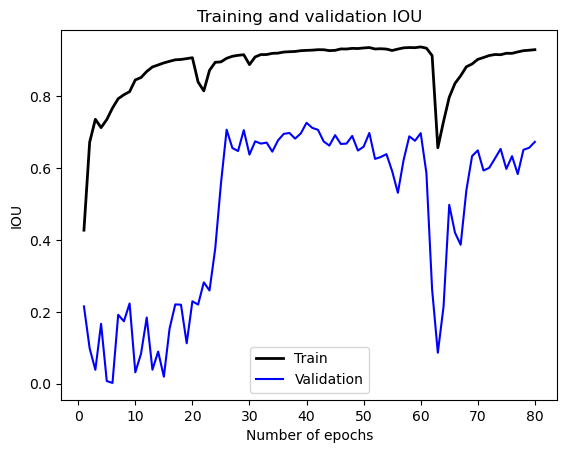

In [7]:
iou_score = history.history['iou_score']
validation_iou_score = history.history['val_iou_score']

plt.plot(number_epochs, iou_score, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_iou_score, 'b', label='Validation')
plt.title('Training and validation IOU')
plt.xlabel('Number of epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()